08/16/2020

2CR2_rna_brainmap_m1_comp

similar t
figure out what the rnaseq 


In [204]:
library(pheatmap)  
library(tidyverse)
library(ggfortify)
library(RColorBrewer)
library(viridis)
library(reshape2)
library(Rtsne)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)

library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [3]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}


In [4]:
save_prefix = '../data/processed/fig1/rna/'

# 1. Read in RNA file 

In [5]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_log_bin = rna_df_tissue_log
rna_df_tissue_log_bin[rna_df_tissue_log<0] = 0
rna_df_tissue_log_bin[rna_df_tissue_log>0] = 1

rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


In [6]:
colnames(rna_df_tissue)

[1] "Astrocytes" "SL_D0"      "SL_D2"      "SLC_D0"     "SLC_D2"    
[6] "H9_D0"      "H9_D2"      "H9_D10"     "H9_D28"

In [7]:
dim(rna_df_tissue)
head(rna_df_tissue)

[1] 23686     9

,Astrocytes,SL_D0,SL_D2,SLC_D0,SLC_D2,H9_D0,H9_D2,H9_D10,H9_D28
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,18.660,7.230,4.01666667,6.993333333,3.616666667,12.485,7.470000000,5.27,5.475
A1BG-AS1,0.430,2.040,2.71000000,1.656666667,2.700000000,0.915,2.770000000,3.30,3.710
A1CF,0.010,0.015,0.02666667,0.010000000,0.003333333,0.000,0.006666667,0.11,0.160
A2M,50.670,0.055,2.48333333,0.156666667,6.546666667,0.020,15.666666667,3.74,2.970
A2M-AS1,0.070,2.580,1.67000000,0.996666667,2.160000000,0.285,0.680000000,5.34,7.985
A2ML1,0.055,0.115,0.01333333,0.006666667,0.000000000,5.020,1.066666667,0.06,0.000


In [236]:
# brainspan_expr_gene_t = cbind(t(brainspan_expr_gene), brainspan_sample_meta_structure)
rna_df_tissue_t = t(rna_df_tissue)
nzv_cols <- nearZeroVar(rna_df_tissue_t)
dim(rna_df_tissue_t)
if(length(nzv_cols) > 0) rna_df_tissue_t <- rna_df_tissue_t[, -nzv_cols]
dim(rna_df_tissue_t)


[1]     9 23686

[1]     9 20798

In [237]:
pca_rna <- prcomp(rna_df_tissue_t, scale. = TRUE)


In [242]:
summary(pca_rna)

Importance of components:
                           PC1     PC2     PC3     PC4      PC5      PC6
Standard deviation     81.2129 68.2877 53.5467 49.4725 44.44873 29.28520
Proportion of Variance  0.3171  0.2242  0.1379  0.1177  0.09499  0.04124
Cumulative Proportion   0.3171  0.5413  0.6792  0.7969  0.89188  0.93311
                            PC7     PC8       PC9
Standard deviation     27.35997 25.3493 2.457e-14
Proportion of Variance  0.03599  0.0309 0.000e+00
Cumulative Proportion   0.96910  1.0000 1.000e+00

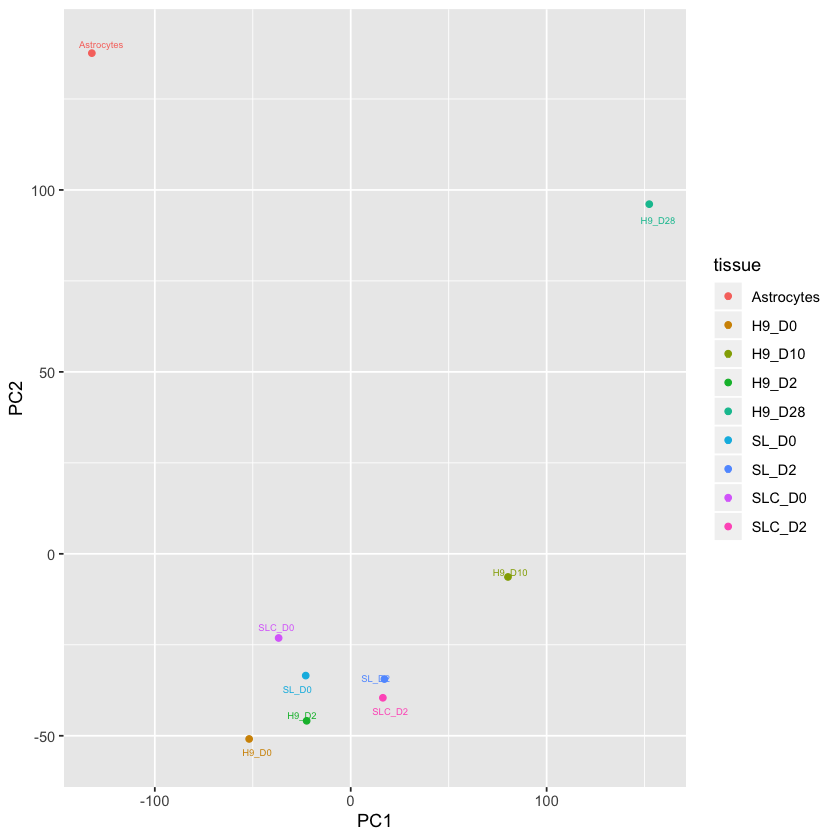

In [243]:
# autoplot(pca_rna)
ggplot(cbind(pca_rna$x, data.frame(tissue=rownames(rna_df_tissue_t))), aes(x=PC1, y=PC2, color=tissue,label=tissue))+
    geom_point()+
  geom_text(size=2,position=position_jitter(width=5,height=5))

# 2 (TODO) Get 293T data


# 3. get brainspan data

https://www.brainspan.org/rnaseq/searches?exact_match=false&search_term=shisa9&search_type=gene



In [8]:
brainspan_expr = read.csv('../data/external/brainspan_genes_matrix_csv/expression_matrix.csv')
brainspan_gene_meta = read.csv('../data/external/brainspan_genes_matrix_csv/rows_metadata.csv')
brainspan_sample_meta = read.csv('../data/external/brainspan_genes_matrix_csv/columns_metadata.csv')

In [9]:
dim(brainspan_expr)
dim(brainspan_gene_meta)
dim(brainspan_sample_meta)

[1] 52375   525

[1] 52376     5

[1] 524   8

there are 52375 genes and 524 samples (remove -X1)

In [10]:
brainspan_gene_meta_sel = dplyr::select(brainspan_gene_meta, row_num, gene_symbol)
colnames(brainspan_gene_meta_sel) = c('X1','gene_symbol')

In [11]:
length(unique(brainspan_gene_meta_sel$gene_symbol))

[1] 47808

In [14]:
### takes awhile
brainspan_expr_gene = brainspan_expr%>%
    left_join(brainspan_gene_meta_sel, by="X1")%>%
    dplyr::select(-X1)%>%
    filter(gene_symbol %in% rownames(rna_df_tissue))%>%
    group_by(gene_symbol)%>%
    summarise_each(mean)%>%
    column_to_rownames("gene_symbol")
colnames(brainspan_expr_gene) = 1:dim(brainspan_expr_gene)[2]

In [15]:
dim(brainspan_expr_gene)
head(brainspan_expr_gene)

[1] 20346   524

,1,2,3,4,5,6,7,8,9,10,⋯,515,516,517,518,519,520,521,522,523,524
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.781851,1.049014,0.571314,0.493764,0.966705,0.608262,0.666283,0.529275,0.583802,0.759015,⋯,2.700484,12.962353,1.263670,0.945322,1.436827,0.793774,3.549536,8.240087,3.871509,2.793416
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027333,⋯,0.000000,0.000000,0.019806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A2M,11.034128,11.628476,14.229826,9.377762,18.883503,10.508559,8.237947,5.281213,7.390115,10.928482,⋯,16.550633,26.621198,24.760916,11.340734,12.291854,10.426193,21.642531,15.590068,35.984485,17.935649
A2ML1,0.001989,0.003898,0.015202,0.005241,0.010131,0.054570,0.015367,0.000000,0.008317,0.000000,⋯,0.119506,0.000000,0.189177,0.113420,0.068312,0.094210,0.156963,0.111793,0.314517,0.097503
A2MP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028929,0.000000,0.000000,0.000000,⋯,0.265157,0.061107,0.082117,0.000000,0.136880,0.031545,0.199813,0.253627,0.202267,0.075709
A4GALT,0.453586,0.335722,0.625994,0.440992,0.749776,0.430838,0.320377,0.509958,0.338337,0.289529,⋯,0.850676,1.603373,0.956981,0.284022,0.450942,0.297723,0.581589,0.576644,1.551583,0.760120


In [16]:
brainspan_expr_gene_sel = brainspan_expr_gene[rownames(brainspan_expr_gene)%in% rownames(rna_df_tissue),]
dim(brainspan_expr_gene_sel)

[1] 20346   524

In [17]:
write.csv(brainspan_expr_gene_sel, paste0(save_prefix, 'brainspan_expr_gene_sel.csv'))

In [73]:
brainspan_sample_meta_structure = brainspan_sample_meta%>%
    column_to_rownames("column_num")#%>%
#     dplyr::select(structure_acronym)
head(brainspan_sample_meta_structure)

,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)
3,13058,H376.IIA.51,8 pcw,M,10361,AMY,amygdaloid complex
4,13058,H376.IIA.51,8 pcw,M,10550,MGE,medial ganglionic eminence
5,13058,H376.IIA.51,8 pcw,M,10243,STC,posterior (caudal) superior temporal cortex (area 22c)
6,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip


In [74]:
acr_to_name = brainspan_sample_meta%>%
    dplyr::select(structure_acronym, structure_name)%>%
    distinct()%>%
    arrange(structure_acronym)
acr_to_name

structure_acronym,structure_name
<fct>,<fct>
A1C,primary auditory cortex (core)
AMY,amygdaloid complex
CB,cerebellum
CBC,cerebellar cortex
CGE,caudal ganglionic eminence
DFC,dorsolateral prefrontal cortex
DTH,dorsal thalamus
HIP,hippocampus (hippocampal formation)
IPC,posteroventral (inferior) parietal cortex


In [20]:
dim(brainspan_sample_meta)
head(brainspan_sample_meta)

[1] 524   8

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
,<int>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
2,2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)
3,3,13058,H376.IIA.51,8 pcw,M,10361,AMY,amygdaloid complex
4,4,13058,H376.IIA.51,8 pcw,M,10550,MGE,medial ganglionic eminence
5,5,13058,H376.IIA.51,8 pcw,M,10243,STC,posterior (caudal) superior temporal cortex (area 22c)
6,6,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip


In [51]:
# brainspan_expr_gene_t = cbind(t(brainspan_expr_gene), brainspan_sample_meta_structure)
brainspan_expr_gene_t = t(brainspan_expr_gene)
nzv_cols <- nearZeroVar(brainspan_expr_gene_t)
dim(brainspan_expr_gene_t)
if(length(nzv_cols) > 0) brainspan_expr_gene_t <- brainspan_expr_gene_t[, -nzv_cols]
dim(brainspan_expr_gene_t)

[1]   524 20346

[1]   524 18469

In [52]:
head(brainspan_expr_gene_t)

,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
1,0.781851,0,11.034128,0.001989,0,0.453586,0.000000,19.97801,5.572849,0.000000,⋯,16.433721,42.757651,2.108165,3.970869,3.087928,0.015347,13.32635,16.33706,2.391425,7.682335
2,1.049014,0,11.628476,0.003898,0,0.335722,0.000000,14.41722,4.935820,0.032039,⋯,15.485105,33.836940,1.611554,3.658507,4.532883,0.007779,14.70572,24.62639,6.023091,7.741037
3,0.571314,0,14.229826,0.015202,0,0.625994,0.000000,12.61803,3.575889,0.000000,⋯,13.719578,18.344309,2.372206,3.711760,3.558101,0.074752,15.34182,21.61825,3.498350,6.595835
4,0.493764,0,9.377762,0.005241,0,0.440992,0.000000,18.15590,3.418223,0.009843,⋯,17.697482,35.804066,2.226562,4.615456,4.021023,0.028356,15.57476,17.04647,3.469868,7.432113
5,0.966705,0,18.883503,0.010131,0,0.749776,0.000000,13.23740,5.021248,0.000000,⋯,13.137050,19.676082,2.156533,4.425787,3.908647,0.039834,15.75272,28.93876,4.520477,6.822395
6,0.608262,0,10.508559,0.054570,0,0.430838,0.023879,10.59345,2.450199,0.012408,⋯,9.911767,7.168994,1.846997,3.484811,3.550379,0.026993,11.19070,34.38481,5.792667,4.692199


In [53]:
write.csv(brainspan_expr_gene_t, paste0(save_prefix, 'brainspan_expr_gene_t.csv'))

without accounting for donor id

In [56]:
pca_res <- prcomp(brainspan_expr_gene_t, center=TRUE, scale = TRUE)


In [68]:
summary(pca_res)

Importance of components:
                           PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     62.6609 42.62551 36.49605 33.04774 29.89274 25.42682
Proportion of Variance  0.2126  0.09838  0.07212  0.05913  0.04838  0.03501
Cumulative Proportion   0.2126  0.31097  0.38309  0.44222  0.49061  0.52561
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     23.55807 21.56410 19.71589 18.59469 17.15542 15.47332
Proportion of Variance  0.03005  0.02518  0.02105  0.01872  0.01594  0.01296
Cumulative Proportion   0.55566  0.58084  0.60189  0.62061  0.63654  0.64951
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     15.17500 14.01433 13.88168 13.26193 13.03980 12.06149
Proportion of Variance  0.01247  0.01063  0.01043  0.00952  0.00921  0.00788
Cumulative Proportion   0.66197  0.67261  0.68304  0.69257  0.70177  0.70965
                           PC19    PC20    PC21     PC

first 50 components account for 0.83369 of the variance use these to these 50 to make a heatmap

### account for donor id

In [93]:
brainspan_expr_gene_meta = cbind(brainspan_expr_gene_t, brainspan_sample_meta_structure) #pca_res$x[,1:50], brainspan_sample_meta_structure)
brainspan_expr_gene_meta = dplyr::select(brainspan_expr_gene_meta, -age, -gender, -donor_name, -structure_id, -structure_acronym, -structure_name)
head(brainspan_expr_gene_meta)

,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,⋯,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,donor_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.781851,0,11.034128,0.001989,0,0.453586,0.000000,19.97801,5.572849,0.000000,⋯,42.757651,2.108165,3.970869,3.087928,0.015347,13.32635,16.33706,2.391425,7.682335,13058
2,1.049014,0,11.628476,0.003898,0,0.335722,0.000000,14.41722,4.935820,0.032039,⋯,33.836940,1.611554,3.658507,4.532883,0.007779,14.70572,24.62639,6.023091,7.741037,13058
3,0.571314,0,14.229826,0.015202,0,0.625994,0.000000,12.61803,3.575889,0.000000,⋯,18.344309,2.372206,3.711760,3.558101,0.074752,15.34182,21.61825,3.498350,6.595835,13058
4,0.493764,0,9.377762,0.005241,0,0.440992,0.000000,18.15590,3.418223,0.009843,⋯,35.804066,2.226562,4.615456,4.021023,0.028356,15.57476,17.04647,3.469868,7.432113,13058
5,0.966705,0,18.883503,0.010131,0,0.749776,0.000000,13.23740,5.021248,0.000000,⋯,19.676082,2.156533,4.425787,3.908647,0.039834,15.75272,28.93876,4.520477,6.822395,13058
6,0.608262,0,10.508559,0.054570,0,0.430838,0.023879,10.59345,2.450199,0.012408,⋯,7.168994,1.846997,3.484811,3.550379,0.026993,11.19070,34.38481,5.792667,4.692199,13058


In [94]:
pca_res <- prcomp(brainspan_expr_gene_meta, center=TRUE, scale = TRUE)


In [98]:
data.frame(pca_res$rotation)%>%
    rownames_to_column()%>%
    arrange(desc(PC1))

rowname,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC515,PC516,PC517,PC518,PC519,PC520,PC521,PC522,PC523,PC524
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GNPTG,0.01425162,5.394186e-03,-0.0024295227,-0.0024699939,-0.0026712283,-0.0032695870,-2.888454e-03,0.0029912176,0.0026894582,⋯,-0.0026006809,2.177274e-03,-0.0008957477,-2.527962e-04,-3.545710e-04,-0.0002373112,2.454324e-05,-3.739680e-04,1.317831e-03,-0.0016185785
C19orf66,0.01394454,1.136463e-03,0.0013461861,-0.0013014384,-0.0098912299,0.0022228938,2.582194e-03,-0.0032965604,0.0078997450,⋯,0.0034858661,3.094204e-04,-0.0021008621,2.949579e-04,1.441832e-04,-0.0001915945,-1.173224e-03,-6.382497e-04,3.030575e-05,-0.0042579717
ANGPTL6,0.01389873,-1.958454e-05,0.0017146038,-0.0009740023,-0.0101226375,0.0022276957,6.135867e-04,-0.0030577044,0.0068943901,⋯,0.0051329172,2.307184e-03,-0.0026368581,1.778180e-03,-1.442541e-03,0.0001919632,3.902450e-04,-4.114195e-04,8.900606e-04,0.0023301721
IDH3A,0.01377895,-6.945495e-03,-0.0059558904,0.0041172231,-0.0011695615,-0.0026721710,6.541473e-05,0.0007906373,0.0034977850,⋯,0.0003548556,5.111606e-05,-0.0006853945,-2.105903e-04,-1.996005e-03,0.0004395836,7.670929e-04,5.221439e-04,5.980527e-04,0.0008873071
PPAP2A,0.01376982,1.881770e-05,-0.0063005430,0.0028645350,-0.0024647261,0.0012124806,2.705394e-03,-0.0031275301,0.0095244555,⋯,-0.0005898311,-1.251887e-03,-0.0018341063,-3.502292e-04,5.316309e-03,-0.0003519479,-2.657369e-04,-1.115962e-03,8.400691e-04,0.0123086255
FBXO2,0.01371407,1.919089e-03,-0.0016328144,-0.0005583937,0.0017585061,-0.0016520073,-8.863323e-03,0.0064431678,0.0033532286,⋯,-0.0006847289,4.218278e-04,0.0002611714,-8.710139e-04,-2.447718e-03,-0.0022877879,5.598842e-04,-1.295455e-03,2.757908e-04,0.0060038337
CTSA,0.01366535,3.019965e-03,0.0037632148,0.0023058867,-0.0098111825,0.0045191973,9.116282e-04,0.0046825357,0.0064622795,⋯,0.0031724846,4.307074e-04,-0.0011929123,-1.318524e-03,-8.118487e-04,0.0001361950,4.377410e-04,-6.434327e-04,3.618735e-04,0.0036133768
SHISA4,0.01366131,2.880815e-03,-0.0026192448,-0.0063775921,-0.0012085324,0.0018921958,-4.843405e-03,0.0036371490,0.0053134891,⋯,-0.0010365162,2.324317e-03,-0.0007488870,-1.002486e-03,3.407940e-04,-0.0010331060,1.087304e-03,3.412672e-04,5.294074e-04,0.0097875774
PNPO,0.01365010,-3.886795e-03,-0.0009234260,0.0040157906,-0.0059517626,0.0036346538,1.076586e-03,-0.0047066236,0.0095816396,⋯,-0.0014747570,-7.257898e-04,-0.0014413201,-1.556424e-03,1.054537e-03,0.0002622229,-4.506531e-04,2.714693e-03,1.453208e-03,0.0053042898


In [100]:
tail(pca_res$rotation)
head(pca_res$x)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC515,PC516,PC517,PC518,PC519,PC520,PC521,PC522,PC523,PC524
ZYG11A,-0.003082265,0.003682855,0.0010636103,0.0001685651,-0.009289856,-0.0034342471,0.013163931,-0.0035592281,-0.0181032560,-0.0012352348,⋯,0.0008043716,0.0095117795,0.003177329,-0.0166665400,0.0065544739,-0.0012996025,-0.0067622058,0.0022431601,-0.0021080884,-0.003711514
ZYG11B,-0.007552664,-0.017223012,-0.0038934752,0.0030809631,0.001716053,0.0028640830,0.009075970,0.0084905373,-0.0039242156,0.0025841363,⋯,-0.0047030702,0.0013418477,0.001453496,0.0013995691,-0.0013156500,0.0011690485,-0.0012627465,0.0011022734,0.0022034406,-0.009708678
ZYX,-0.002953899,0.009976457,0.0120203807,-0.0028413327,-0.014121833,0.0031045086,0.007312082,0.0080919337,-0.0013808868,0.0059627558,⋯,-0.0018006189,-0.0037606748,0.003542151,0.0015520533,-0.0033038328,0.0004522470,0.0007525509,0.0008953684,-0.0031998903,-0.003756621
ZZEF1,-0.008036134,-0.001244694,0.0172883976,0.0125157569,-0.004121216,-0.0006947203,0.002694848,-0.0004047349,0.0078421593,-0.0007175669,⋯,-0.0012608152,-0.0012044952,-0.012340740,0.0022716372,-0.0009032778,-0.0017323672,0.0012120374,-0.0011160715,-0.0006623811,0.015856812
ZZZ3,-0.013709751,-0.002223761,-0.0058982409,0.0078447515,0.002300634,0.0022842863,0.003463751,-0.0026436389,0.0009283745,-0.0072690643,⋯,-0.0037588001,-0.0007871546,0.004889621,-0.0084666255,0.0052382443,-0.0002081696,0.0011721385,0.0010275051,-0.0000334962,0.003783308
donor_id,0.001337083,0.008105422,0.0008188984,-0.0036844378,-0.005939603,0.0150385352,0.016316542,0.0049719150,0.0080611139,0.0150367725,⋯,0.0011585702,0.0001980909,0.001502326,0.0009987542,0.0010934510,0.0018961762,-0.0009471285,0.0001365722,0.0001110982,0.001333004


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC515,PC516,PC517,PC518,PC519,PC520,PC521,PC522,PC523,PC524
1,-112.95431,50.79480,-104.38842,40.035243,-52.28414,7.779809,-64.68243,12.5861912,-5.336623,7.688787,⋯,0.44271134,-0.226683736,0.0891583,-0.07525398,0.08004384,-4.385887e-03,0.0010656828,-8.185009e-04,-1.062522e-05,2.519859e-14
2,-112.29662,45.37526,-48.53521,65.435587,-32.57945,7.000072,-50.86484,-1.7519436,-7.983346,10.621174,⋯,-0.35309935,0.136147327,0.1097445,-0.47285697,-0.41663255,1.100771e-05,0.0018565562,5.754502e-05,3.835106e-05,1.075529e-15
3,-86.33016,17.34352,-39.57969,2.489126,-16.19142,9.551859,-29.65795,6.1650603,-12.084541,-13.974272,⋯,-0.14288717,0.017680896,0.2549518,-0.67295015,-0.01589463,-1.010732e-03,-0.0013017758,2.185640e-04,-2.185987e-04,-3.647777e-14
4,-107.10567,41.62331,-74.52974,42.269299,-36.12133,10.334979,-55.04723,0.5290065,-20.081869,-3.237247,⋯,-0.10143144,0.261317933,-0.3205022,-0.16533816,-0.09399370,-2.489699e-03,0.0010834089,-1.261689e-04,-1.452376e-05,4.600487e-14
5,-90.18300,29.92962,-39.83053,28.483007,-14.10656,19.021698,-22.66029,16.8304208,-1.494963,1.675640,⋯,-0.39816800,-0.214962890,-0.2145099,0.58394037,-0.34609851,1.198527e-03,0.0015282232,-5.534367e-04,5.791088e-05,-2.819966e-14
6,-65.14320,27.20606,18.10567,-6.794294,-23.50944,9.701329,-11.80219,1.0262625,-35.910804,-23.598596,⋯,-0.02773809,0.008680123,-0.1128132,-0.05606756,0.01519728,1.320135e-03,-0.0008508672,2.945852e-05,-2.588189e-05,-8.840151e-15


In [101]:
brainspan_expr_gene_meta = cbind(brainspan_expr_gene_t, brainspan_sample_meta_structure) #pca_res$x[,1:50], brainspan_sample_meta_structure)


[1] ""

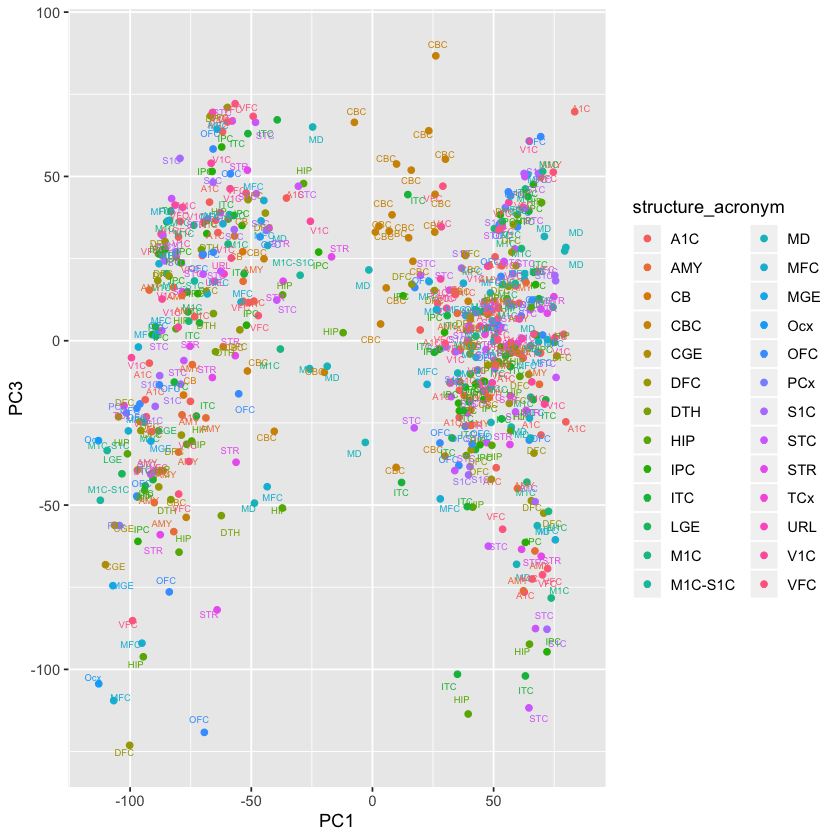

In [125]:
# autoplot(pca_res, data = brainspan_expr_gene_meta, colour = 'structure_acronym')
ggplot(cbind(pca_res$x, brainspan_sample_meta_structure), aes(x=PC1, y=PC3, color=structure_acronym,label=structure_acronym))+
    geom_point()+
  geom_text(size=2,position=position_jitter(width=5,height=5))
''#+geom_text()

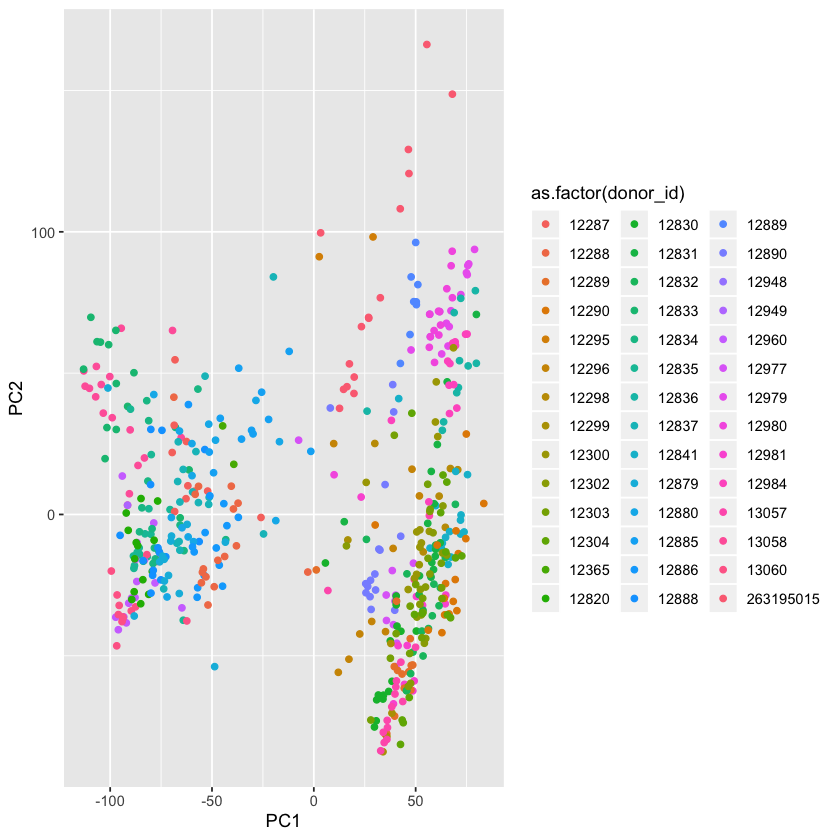

In [124]:
ggplot(cbind(pca_res$x, brainspan_sample_meta_structure), aes(x=PC1, y=PC2, color=as.factor(donor_id)))+geom_point()

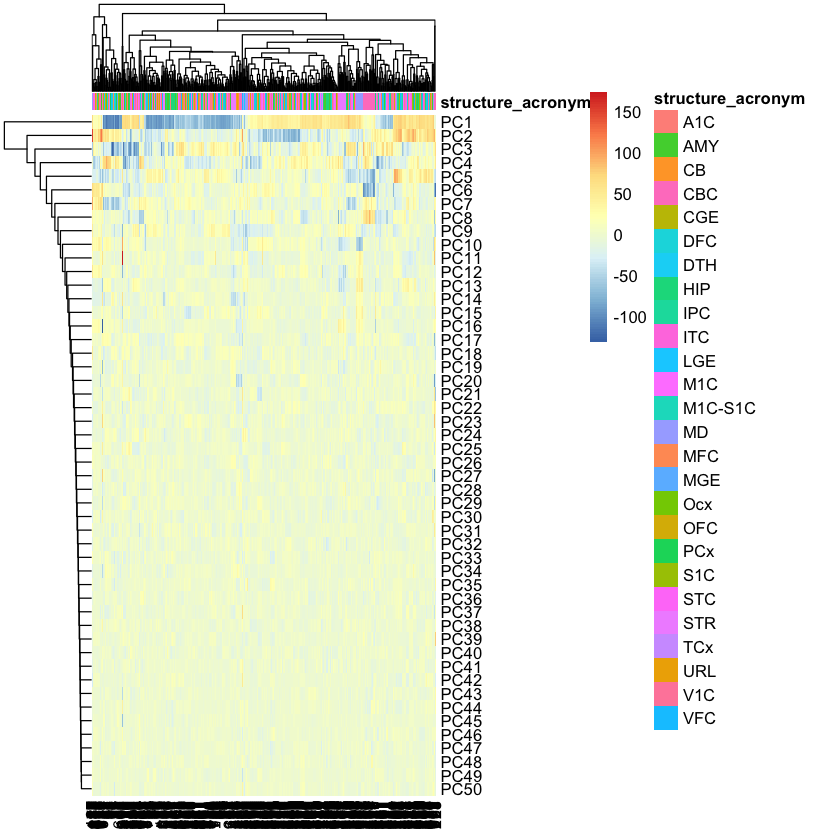

In [121]:
pheatmap(t(pca_res$x[,1:50]),annotation_col=dplyr::select(brainspan_sample_meta_structure,structure_acronym))

# add in rna_df_tissue


In [152]:
rna_df_tissue_sel = rna_df_tissue[rownames(rna_df_tissue) %in% colnames(brainspan_expr_gene_t),]



dim(rna_df_tissue_sel)

[1] 18469     9

#### only rna_df prcomp

In [235]:
pca_rna = prcomp(t(rna_df_tissue_sel), scale=TRUE, center=TRUE)

ERROR: Error in prcomp.default(t(rna_df_tissue_sel), scale = TRUE, center = TRUE): cannot rescale a constant/zero column to unit variance


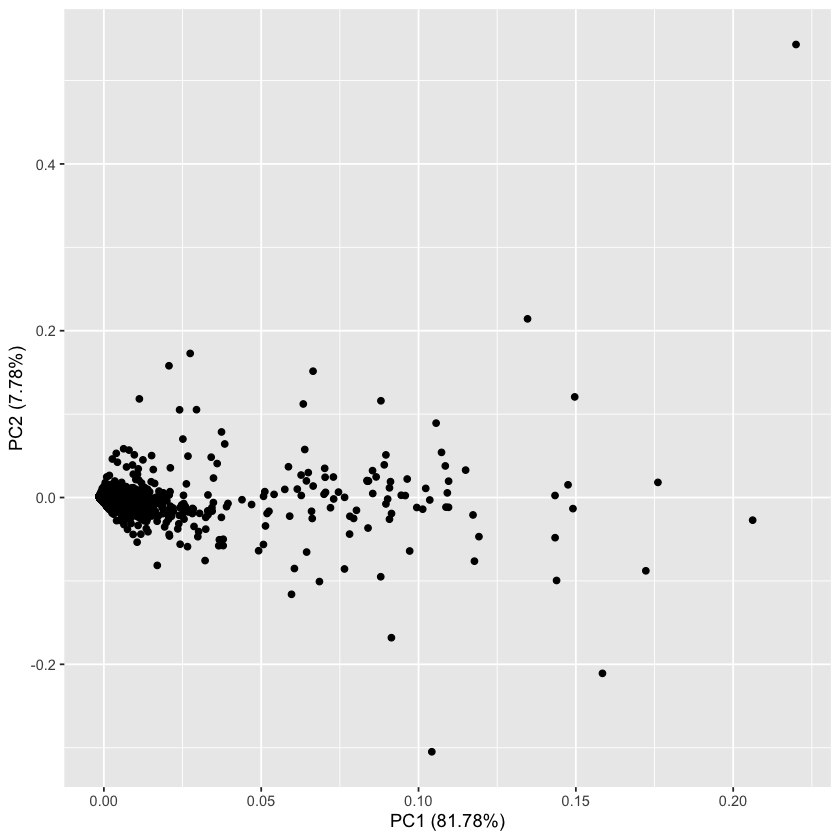

In [232]:
autoplot(pca_rna, data = rna_df_tissue_sel)

In [129]:
brainspan_sample_meta_structure$source = 'brainspan'

In [176]:
# colnames(brainspan_sample_meta_structure)

In [177]:
# colnames(meta_rna)

In [171]:
brainspan_expr_gene_t_tissue = cbind(brainspan_expr_gene_t, dplyr::select(brainspan_sample_meta_structure, structure_acronym))%>%
    group_by(structure_acronym)%>%
    summarise_each(mean)
    

In [173]:
write.csv(brainspan_expr_gene_t_tissue, paste0(save_prefix, 'brainspan_expr_gene_t_tissue.csv'))

In [174]:
brainspan_expr_gene_t_tissue = column_to_rownames(brainspan_expr_gene_t_tissue, "structure_acronym")
head(brainspan_expr_gene_t_tissue)

,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1C,2.0730041,0.007017806,30.275905,0.34215697,0.07488152,1.0997817,0.01962203,6.358766,4.118813,0.06310452,⋯,5.787505,1.420416,1.560443,3.619885,2.521497,0.02455281,17.12007,20.61382,4.238008,3.968206
AMY,2.3337408,0.008834667,30.576676,0.49606385,0.08455179,1.1918605,0.03074212,8.184450,3.180154,0.03163721,⋯,6.752544,6.448841,1.463237,3.375435,2.998116,0.03811509,14.29830,18.07738,4.093876,4.729322
CB,0.5463363,0.004733667,8.914792,0.08099967,0.02137767,1.1690703,0.00000000,10.219521,2.284872,0.02538467,⋯,12.392888,6.790210,2.374688,4.086244,4.272903,0.05795967,18.77170,33.86956,5.896607,5.171324
CBC,3.0679737,0.009572552,28.010295,0.10785448,0.07228107,1.3368455,0.01834093,8.713176,1.501258,0.05883810,⋯,4.929176,3.225485,1.283196,3.457040,3.293390,0.10647845,15.64588,36.60498,5.696269,3.294823
CGE,0.7225695,0.000000000,8.709259,0.05313500,0.03194500,0.3825850,0.00000000,20.703646,3.566759,0.00619550,⋯,15.404613,37.305183,2.036205,4.849229,5.668076,0.02927600,16.58821,28.63526,4.949292,7.613434
DFC,2.4825083,0.026394143,26.533456,0.27862466,0.05157217,0.8678225,0.02497377,7.039464,4.253710,0.05669574,⋯,6.019348,3.523183,1.425775,3.250983,2.598355,0.01775011,16.92452,19.74215,3.959177,3.860113


In [193]:
# meta_rna = data.frame(donor_id	= 1:length(colnames(rna_df_tissue_sel)), donor_name='none', age = 'none', gender='none',
#         structure_id= 1:length(colnames(rna_df_tissue_sel)), structure_acronym = colnames(rna_df_tissue_sel),	structure_name = colnames(rna_df_tissue_sel),
#                      source='inhouse')	

# meta_rna = rbind(brainspan_sample_meta_structure, meta_rna)


meta_brainspan_tissue = data.frame(tissue=rownames(brainspan_expr_gene_t_tissue), source='brainspan')
meta_rna = data.frame(tissue=colnames(rna_df_tissue_sel),source='inhouse')
meta_rna = rbind(meta_brainspan_tissue, meta_rna)
rownames(meta_rna) = meta_rna$tissue

In [179]:
# data_rna = rbind(brainspan_expr_gene_t,t(rna_df_tissue_sel))
data_rna = rbind(brainspan_expr_gene_t_tissue,t(rna_df_tissue_sel))

data_rna_norm = t(apply(data_rna, 1, function(x)(x-min(x))/(max(x)-min(x))))


In [180]:
pca_res <- prcomp(data_rna_norm, center=TRUE, scale = TRUE)


In [181]:
summary(pca_res)

Importance of components:
                           PC1     PC2      PC3      PC4      PC5     PC6
Standard deviation     93.8189 53.9624 38.16226 30.35088 27.29753 22.3322
Proportion of Variance  0.4766  0.1577  0.07885  0.04988  0.04035  0.0270
Cumulative Proportion   0.4766  0.6342  0.71310  0.76298  0.80333  0.8303
                           PC7     PC8      PC9     PC10     PC11     PC12
Standard deviation     21.5292 18.5340 17.30828 16.12169 15.66339 14.03761
Proportion of Variance  0.0251  0.0186  0.01622  0.01407  0.01328  0.01067
Cumulative Proportion   0.8554  0.8740  0.89025  0.90432  0.91760  0.92827
                           PC13    PC14     PC15     PC16    PC17    PC18
Standard deviation     13.05146 12.3847 10.64970 10.23544 9.90932 9.25481
Proportion of Variance  0.00922  0.0083  0.00614  0.00567 0.00532 0.00464
Cumulative Proportion   0.93749  0.9458  0.95194  0.95761 0.96293 0.96757
                          PC19    PC20    PC21    PC22    PC23    PC24   PC25
Stan

first 50 comp are 0.86760 explained variance

[1] ""

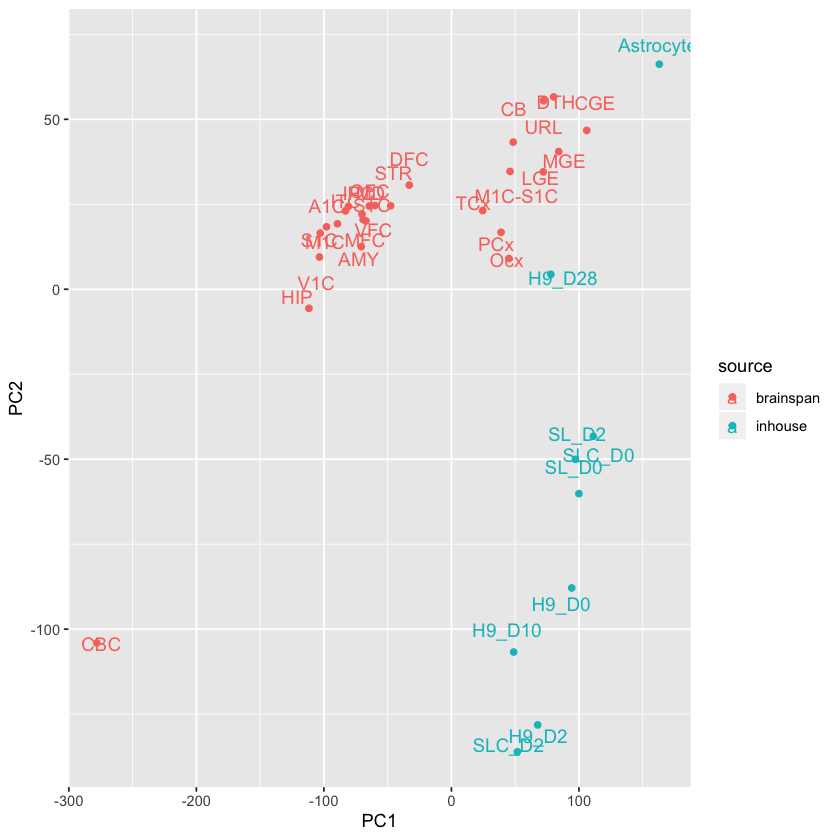

In [200]:
# autoplot(pca_res, data = brainspan_expr_gene_meta, colour = 'structure_acronym')
ggplot(cbind(pca_res$x, meta_rna), aes(x=PC1, y=PC2, color=source,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=10,height=10))
''#+geom_text()

In [208]:
tsne_results <- Rtsne(pca_res$x, perplexity=10, check_duplicates = FALSE)

In [214]:
tsne_plot_df = data.frame(tsne_results$Y)
rownames(tsne_plot_df) = rownames(pca_res$x)
tsne_plot_df$tissue =  rownames(pca_res$x)

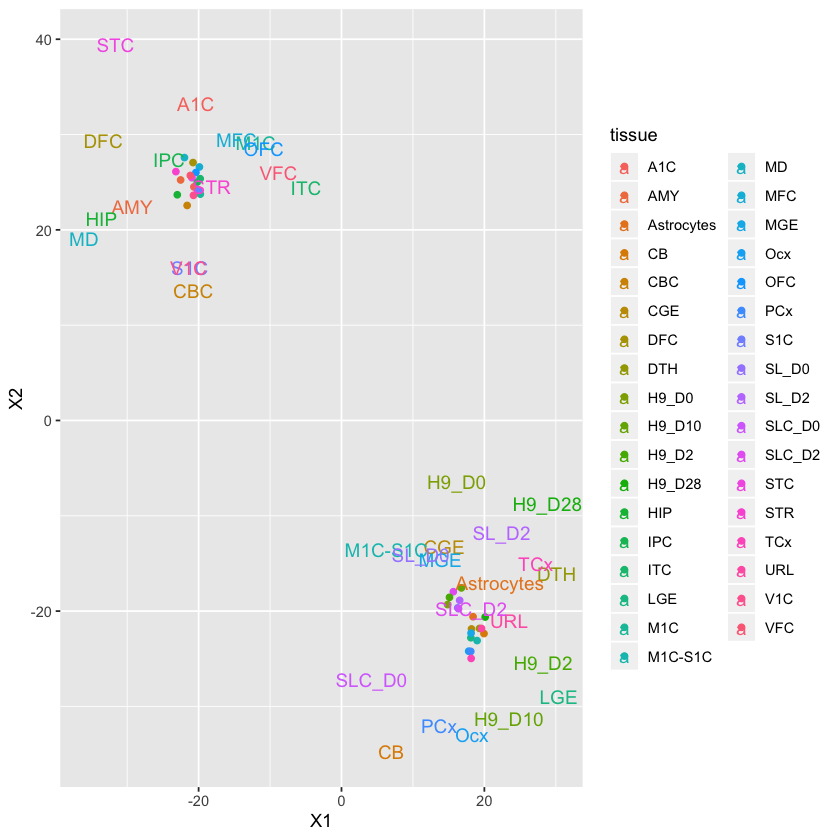

In [220]:
ggplot(tsne_plot_df,aes(x=X1,y=X2,color=tissue,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=15,height=15))
ggsave(paste0(save_prefix,'tsne_tissues.pdf'),width=8,height=8)

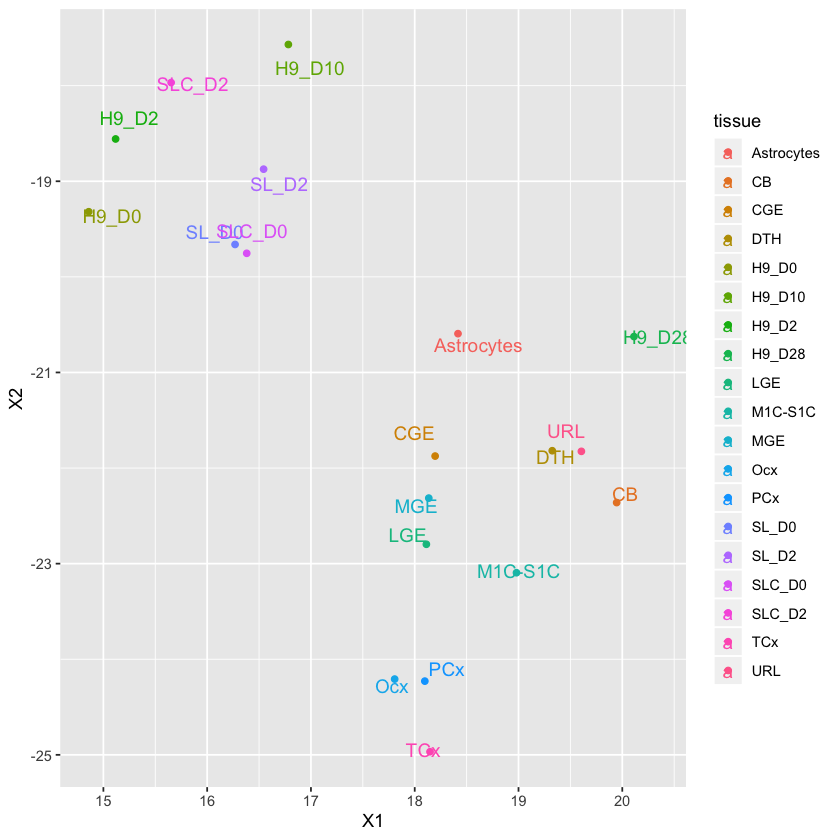

In [227]:
ggplot(filter(tsne_plot_df, (X1>0) & (X2<0)),aes(x=X1,y=X2,color=tissue,label=tissue))+
    geom_point()+
  geom_text(size=4,position=position_jitter(width=.25,height=.25))
ggsave(paste0(save_prefix,'tsne_tissues_filt.pdf'),width=8,height=8)

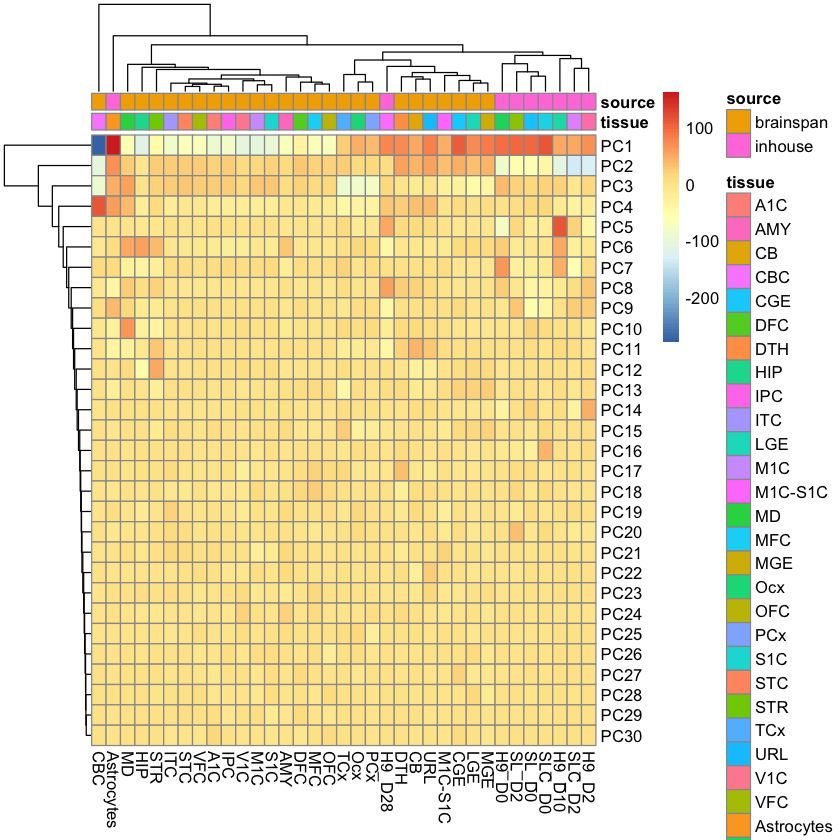

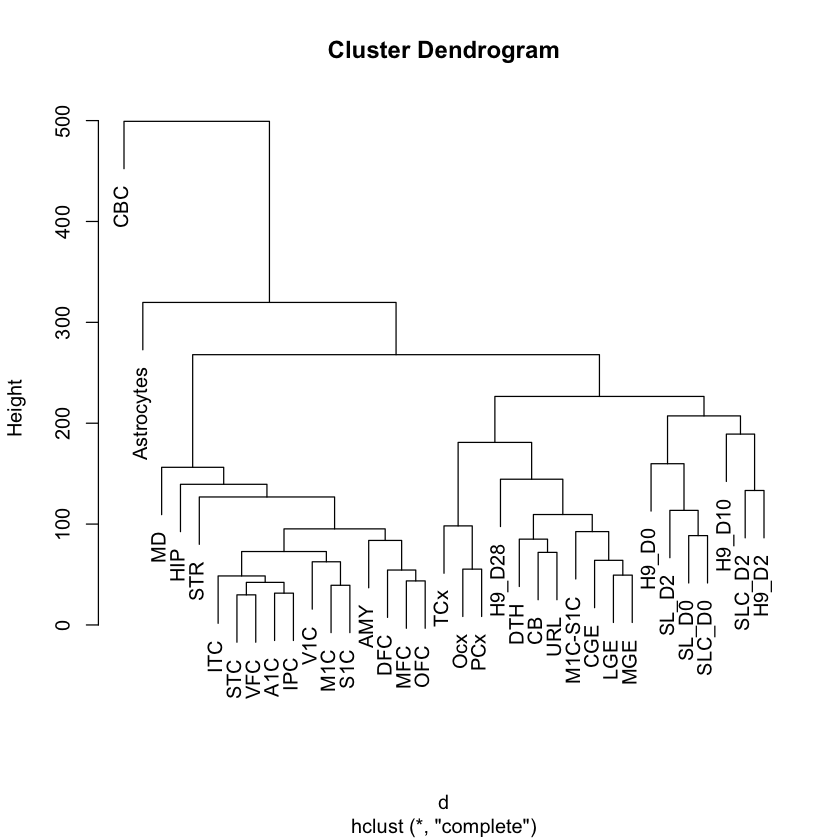

In [198]:
p = pheatmap(t(pca_res$x[,1:30]),annotation_col=meta_rna)
par(bg='white')
plot(p$tree_col)

In [199]:
acr_to_name

structure_acronym,structure_name
<fct>,<fct>
A1C,primary auditory cortex (core)
AMY,amygdaloid complex
CB,cerebellum
CBC,cerebellar cortex
CGE,caudal ganglionic eminence
DFC,dorsolateral prefrontal cortex
DTH,dorsal thalamus
HIP,hippocampus (hippocampal formation)
IPC,posteroventral (inferior) parietal cortex
